# Tutorial 1: 10X Visium data

SpaCross can be used to process 10X Visium data to extract low-dimension representation. In this tutorial, we use sample #151675 from Dorsolateral Prefrontal Cortex (DLPFC) dataset to introduce the analysis pipeline. 

The raw Visium data can be downloaded from http://spatial.libd.org/spatialLIBD/.

# [1] Loading packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import pandas as pd
import scanpy as sc
import matplotlib
import yaml
from pathlib import Path
import os
from sklearn.decomposition import PCA

In [2]:
import SpaCross as TOOLS

# [2] Loading configuration

In [3]:
# loads a YAML configuration file that defines key settings such as data preprocess, model architecture, and training hyperparameters.
with open('../Config/DLPFC.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

# [3] Basic settings

In [4]:
# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
# the number of clusters
tissue_name = "151675"
num_clusters = 7
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# sets the data loading path; please modify it according to the actual location of your dataset.
data_root = Path('D:\\project\\datasets\\DLPFC\\')

# [4] Loading data

In [5]:
count_file = tissue_name + "_filtered_feature_bc_matrix.h5"
adata = sc.read_visium(data_root / tissue_name, count_file=count_file)
adata.var_names_make_unique()

# [5] Preprocessing

In [6]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['data']['top_genes'])
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

# sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

# [6] Constructing neighborhood graph

In [7]:
edge_index = TOOLS.graph_construction(adata, config['data']['k_cutoff'])

# [7] Training SpaCross

In [8]:
# define model
model = TOOLS.SC_pipeline(adata, edge_index=edge_index, num_clusters=num_clusters, device=device, config=config, imputation=False)

# train model
model.trian()

# get embedding
embed, _ = model.process()
adata.obsm["embed"] = embed

Epoch 299 total loss=1.514 recon loss=0.962 mean loss=0.403 tri loss=1.361: 100%|██████████| 300/300 [00:10<00:00, 29.38it/s]


# [8] Clustering

In [9]:
tool = 'mclust' # mclust and kmeans
adata.obs[tool] = TOOLS.clustering(z=embed, n_clust=num_clusters, num_seed=1, method=tool)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


# [9] Add Ground Truth

In [10]:
##### Load layer_guess label, if have
truth_path = "D:\\project\\datasets\\DLPFC\\" + tissue_name + '/' + tissue_name + '_truth.txt'
Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
Ann_df.columns = ['ground_truth']
adata.obs['ground_truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']

# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# [10] Calculate metric

In [11]:
ARI, ACC, DIS = TOOLS.get_metrics(adata, 'ground_truth', tool)
print(f"DLPFC-({tissue_name}): ARI:{round(ARI, 4)} ACC:{round(ACC, 4)} DIS:{round(DIS, 4)}")

DLPFC-(151675): ARI:0.6832 ACC:0.7613 DIS:0.0394


# [11] Plotting spatial clustering result

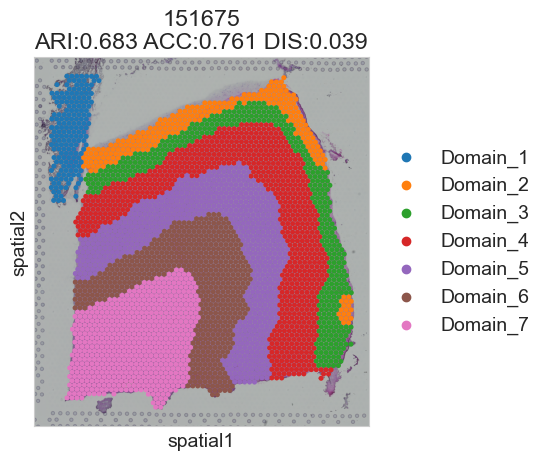

In [12]:
# Set global fonts and font sizes
matplotlib.rcParams['font.family'] = 'Arial'     
matplotlib.rcParams['font.size'] = 14  

maps = {'6': 'Domain_1', '5': 'Domain_2', '7': 'Domain_3', '1': 'Domain_4', '2': 'Domain_5', '4': 'Domain_6', '3': 'Domain_7'}
values = [maps[value] for value in adata.obs[tool]]
data = {'cluster': values}
df = pd.DataFrame(data, index=adata.obs[tool].index)
adata.obs['domain'] = df

# Plotting spatial domain
sc.pl.spatial(
    adata,
    color=['domain'],
    spot_size=140,
    title=tissue_name + '\nARI:' + str(round(ARI, 3)) + ' ACC:' + str(round(ACC, 3)) + ' DIS:' + str(round(DIS, 3)),
    show=True
)

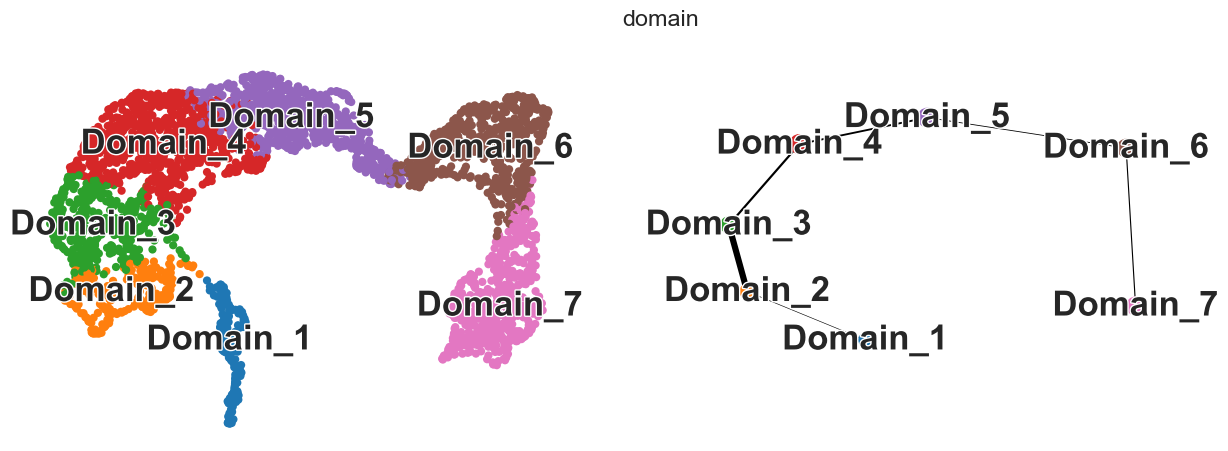

In [13]:
# Plotting UMAP & PAGA
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=16, use_rep="embed")
sc.tl.umap(adata)
sc.tl.paga(adata, groups='domain')
sc.pl.paga_compare(adata, legend_fontsize=25, frameon=False, size=140, legend_fontoutline=2, show=True)